# Going from parameter sampling to model sampling

Using Markov Chain Monte Carlo (MCMC) to generate samples from an unknown or analytically intractible problem is a fairly useful technique that, in the context of force field parameterization, allows for us to understand the relative fitness of sets of parameters.  

However, one of the enduring challenges of force field science is deciding the level of theory required to appropriately model a chemical system.  In this context, we would like to be able to produce not only a probability distribution of parameters, but a probability distribution of *models* - giving us an estimate of relative fitness of different *model* functional forms.

Fortunately, the reversible jump Markov Chain Monte Carlo (RJMC) technique can be used to extend the method of MCMC from sets of parameters to sets of models with *disjoint* parameters.

Functionally, this is accomplished by modifying the M-H acceptance ratio with an additional term that accounts for the proposal of moves between models:

Standard MCMC acceptance ratio: 
$$\begin{equation}
\pi(x'|x) = \mathrm{min} \left \{1,\alpha\right \} \, ; \,  \alpha(x', x) = \frac{p(x')j(x'|x)}{p(x)j(x|x')}
\end{equation}  
$$

Adapted RJMC acceptance ratio:
$$\begin{equation}
\alpha(x',x') = \frac{p(x')j(x'|x)g'(u')}{p(x)j(x|x')g(u)}\left | \frac{\partial(x',u')}{\partial(x,u)} \right |
\end{equation} $$

This adds an additional term $g(u)$ that constitutes a proposal distribution for a dummy variable $u$, and a Jacobian term that matches dimensions.


In this example, we will take a simple fluid model, the 2-center Lennard Jones + Quadrupole (2CLJQ) model, decompose it into 3 models with different levels of complexity, and use reversible jump Monte Carlo to make quantitative estimates of the relative fitness of these models.

## Models considered
The 2CLJQ model has 4 parameters: $(\epsilon, \sigma, L, Q)$. $\epsilon$ and $\sigma$ are standard L-J parameters, $L$ is the anisotropic bond length between two identical L-J sites, and $Q$ is the quadrupole moment.

The three levels of complexity we choose are: 

UA: Variable $\epsilon$ and $\sigma$, fixed $L$, $Q$ set to 0 (no quadrupole moment) (2 parameter model)

AUA: Variable $\epsilon$, $\sigma$ and $L$, $Q$ set to 0 (no quadrupole moment) (3 parameter model)

AUA+Q: Variable $\epsilon$, $\sigma$, $L$, and $Q$ (4 parameter model)

## Bayes Factors

In Bayesian inference, a standard form of evidence between models is called the Bayes Factor, which consists of the ratio between two model posteriors:

$$B_{01} = \frac{P(M_0|D)}{P(M_1|D)}$$


In [28]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  3 19:34:17 2018

Implementation of RJMC between AUA and AUA-Q models.

    
"""

from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from LennardJones_correlations import LennardJones
from LennardJones_2Center_correlations import LennardJones_2C
from scipy.stats import distributions
from scipy.stats import linregress
from scipy.optimize import minimize
import random as rm
from pymc3.stats import hpd
from RJMC_auxiliary_functions import *
from datetime import date
import copy

In [29]:
# Here we have chosen ethane as the test case


compound='C2H6'
ff_params_ref,Tc_lit,M_w,thermo_data,NIST_bondlength=parse_data_ffs(compound)
#Retrieve force field literature values, constants, and thermo data


T_min = 0.55*Tc_lit[0]
T_max = 0.95*Tc_lit[0]
n_points=10

#Select temperature range of data points to select, and how many temperatures within that range to use data at. 


thermo_data=filter_thermo_data(thermo_data,T_min,T_max,10)
#Filter data to selected conditions.


uncertainties=calculate_uncertainties(thermo_data,Tc_lit[0])
#Calculate uncertainties for each data point, based on combination of experimental uncertainty and correlation uncertainty

thermo_data_rhoL=np.asarray(thermo_data['rhoL'])
thermo_data_Pv=np.asarray(thermo_data['Pv'])
thermo_data_SurfTens=np.asarray(thermo_data['SurfTens'])
#Convert dictionaries to numpy arrays


# Substantiate LennardJones class
compound_2CLJ = LennardJones_2C(M_w)



   
# Calculate the estimated standard deviation
sd_rhol = uncertainties['rhoL']/2.
sd_Psat = uncertainties['Pv']/2.
sd_SurfTens = uncertainties['SurfTens']/2

# Calculate the precision in each property
t_rhol = np.sqrt(1./sd_rhol)
t_Psat = np.sqrt(1./sd_Psat)                                   
t_SurfTens = np.sqrt(1./sd_SurfTens)                                   

# Initial values for the Markov Chain

guess_0 = [0,*ff_params_ref[1]]
guess_1 = [1,*ff_params_ref[0]]
guess_2 = [2,*ff_params_ref[2]]
# Create initial starting points based on previous optimization data

guess_2[3] = NIST_bondlength
#Modify Bond length for UA model to experimental value
#guess_2 = [1,eps_lit3_AUA,sig_lit3_AUA,Lbond_lit3_AUA,Q_lit3_AUA] 


## Priors

Since Bayes' rule over model and parameter space is defined as $P(M,\Theta|D) \propto P(D| M,\Theta)P(M,\Theta)$, the model posterior $P(M_i|D)$ is obtained by integrating over the parameter space $\Theta_i$ corresponding to the model $M_i$:

$$ P(M_i|D) = \int P(\Theta_i|M_i) P(D| \Theta_i,M_i) \mathrm{d}\Theta_i $$

In this context, we can see that the model posterior, and therefore the Bayes Factor, is dependent on the prior $P(\Theta_i|M_i)$.

Therefore, it is important to set our priors in a way that does a good job of covering the space that we want to sample, but not too much additional space.  It is also important to make sure that all important values are sampled, so that we do not miss important areas.  For this reason, we choose heavy-tailed logistic priors for the parameters $\epsilon,\sigma,L$, and a tunable gamma prior for $Q$.

In [30]:
#%%
# Simplify notation ( we will use these functions to create priors and draw RVs as needed )
dnorm = distributions.norm.logpdf
dgamma = distributions.gamma.logpdf
duni = distributions.uniform.logpdf
dlogit = distributions.logistic.logpdf

rnorm = np.random.normal
runif = np.random.rand

norm=distributions.norm.pdf
unif=distributions.uniform.pdf

#Select number of properties and which properties (current options are 'rhol','Psat', 'rhol+Psat','All')

properties = 'rhol+Psat'
number_criteria = 'two'


prior_range=0.05

#Uniform Priors (creating uniform priors based on optimization values)
#eps_prior=[ff_params_ref[1][0]*(1-prior_range),ff_params_ref[1][0]*(1+prior_range)]
#sig_prior=[ff_params_ref[1][1]*(1-prior_range),ff_params_ref[1][1]*(1+prior_range)]
#L_prior=[ff_params_ref[1][2]*(1-prior_range),ff_params_ref[1][2]*(1+prior_range)]



#Logistic priors (creating logistic priors based to optimization values)
shape_divide=10

eps_prior=[ff_params_ref[1][0],ff_params_ref[1][0]/shape_divide]
sig_prior=[ff_params_ref[1][1],ff_params_ref[1][1]/shape_divide]
L_prior=[ff_params_ref[1][2],ff_params_ref[1][2]/shape_divide]

#Q priors
#Can use uniform or gamma prior
#Uniform
#Q_prior=[0,0.3]
#Gamma
Q_prior=[1,0,1]

In [31]:
def calc_posterior(model,eps,sig,L,Q):

    logp = 0
    logp += dlogit(sig, *sig_prior)
    logp += dlogit(eps, *eps_prior)  
    #Create priors for parameters common to all models     
    if model == 2:
        Q=0
        #Ensure Q=0 for UA model
    
    elif model == 0:
        Q=0
        logp+=dlogit(L,*L_prior)
        #Add prior over L for AUA model
    
    elif model == 1:
        logp+=dgamma(Q,*Q_prior)
        logp+=dlogit(L,*L_prior)

        #Add priors for Q and L for AUA+Q model
        
    rhol_hat = rhol_hat_models(compound_2CLJ,thermo_data_rhoL[:,0],model,eps,sig,L,Q) #[kg/m3]
    Psat_hat = Psat_hat_models(compound_2CLJ,thermo_data_Pv[:,0],model,eps,sig,L,Q) #[kPa]   
    SurfTens_hat = SurfTens_hat_models(compound_2CLJ,thermo_data_SurfTens[:,0],model,eps,sig,L,Q)     
    #Compute properties at temperatures from experimental data
    
    
    # Data likelihood: Compute likelihood based on gaussian penalty function
    if properties == 'rhol':
        logp += sum(dnorm(thermo_data_rhoL[:,1],rhol_hat,t_rhol**-2.))
        #logp += sum(dnorm(rhol_data,rhol_hat,t_rhol**-2.))
    elif properties == 'Psat':
        logp += sum(dnorm(thermo_data_Pv[:,1],Psat_hat,t_Psat**-2.))
    elif properties == 'rhol+Psat':
        logp += sum(dnorm(thermo_data_rhoL[:,1],rhol_hat,t_rhol**-2.))
        logp += sum(dnorm(thermo_data_Pv[:,1],Psat_hat,t_Psat**-2.))
    elif properties == 'All':
         logp += sum(dnorm(thermo_data_rhoL[:,1],rhol_hat,t_rhol**-2.))
         logp += sum(dnorm(thermo_data_Pv[:,1],Psat_hat,t_Psat**-2.))           
         logp += sum(dnorm(thermo_data_SurfTens[:,1],SurfTens_hat,t_SurfTens**-2))
    return logp
    #return rhol_hat

In [32]:
def jacobian(n_models,n_params,w,lamda,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ):
    jacobian=np.ones((n_models,n_models))
    
    
    
    #Optimum Matching for UA --> AUA
    #jacobian[0,1]=(1/(lamda*w))*(opt_params_AUA_Q[0]*opt_params_AUA_Q[1]*opt_params_AUA_Q[2])/(opt_params_AUA[0]*opt_params_AUA[1]*opt_params_AUA[2])
    #jacobian[1,0]=lamda*(opt_params_AUA[0]*opt_params_AUA[1]*opt_params_AUA[2])/(opt_params_AUA_Q[0]*opt_params_AUA_Q[1]*opt_params_AUA_Q[2])
    jacobian[0,2]=(opt_params_2CLJ[0]*opt_params_2CLJ[1]*opt_params_2CLJ[2])/(opt_params_AUA[0]*opt_params_AUA[1]*opt_params_AUA[2])
    jacobian[2,0]=(opt_params_AUA[0]*opt_params_AUA[1]*opt_params_AUA[2])/(opt_params_2CLJ[0]*opt_params_2CLJ[1]*opt_params_2CLJ[2])
    #Direct transfer for AUA->AUA+Q 
    jacobian[0,1]=1/(lamda*w)
    jacobian[1,0]=w*lamda
    
    
    #jacobian[0,1]=(1/(lamda*w))*(AUA_Q_opt_params[0]*AUA_Q_opt_params[1])/(AUA_opt_params[0]*AUA_opt_params[1])
    #jacobian[1,0]=w*lamda*(AUA_opt_params[0]*AUA_opt_params[1])/(AUA_Q_opt_params[0]*AUA_Q_opt_params[1])
    #jacobian[0,1]=1/(lamda*w)
    #jacobian[1,0]=w*lamda
    
    return jacobian
    

def transition_function(n_models,w):
    transition_function=np.ones((n_models,n_models))
    g_0_1=unif(w,0,1)
    g_1_0=1
    g_0_2=1
    g_2_0=1
    #These are proposal distributions for "new" variables (that exist in one model but not the other).  They have been cleverly chosen to all equal 1
    
    
    q_0_1=1/2
    q_1_0=1
    q_0_2=1/2
    q_2_0=1
    #These are probabilities of proposing a model from one model to another.  
    #The probability is half for moves originating in AUA because they can move either to UA or AUA+Q. We disallow moves between UA and AUA+Q directly 
    
    #Note that this is really times swap_freq but that term always cancels.
    
    
    transition_function[0,1]=g_1_0*q_1_0/(g_0_1*q_0_1)
    transition_function[1,0]=g_0_1*q_0_1/(g_1_0*q_1_0)
    transition_function[0,2]=g_2_0*q_2_0/(g_0_2*q_0_2)
    transition_function[2,0]=g_0_2*q_0_2/(g_2_0*q_2_0)
    #Transition functions enumerated for each 
    
    
    return transition_function

In [33]:
def gen_Tmatrix():
    ''' Generate Transition matrices based on the optimal eps, sig, Q for different models'''
    
    #Currently this is not used for moves between AUA and AUA+Q, because it doesn't seem to help.  Still used for UA and AUA moves
    
    obj_AUA = lambda eps_sig_Q: -calc_posterior(0,eps_sig_Q[0],eps_sig_Q[1],eps_sig_Q[2],eps_sig_Q[3])
    obj_AUA_Q = lambda eps_sig_Q: -calc_posterior(1,eps_sig_Q[0],eps_sig_Q[1],eps_sig_Q[2],eps_sig_Q[3])
    obj_2CLJ = lambda eps_sig_Q: -calc_posterior(2,eps_sig_Q[0],eps_sig_Q[1],eps_sig_Q[2],eps_sig_Q[3])
    
    
    guess_AUA = [guess_0[1],guess_0[2],guess_0[3],guess_0[4]]
    guess_AUA_Q = [guess_1[1],guess_1[2],guess_1[3],guess_1[4]]
    guess_2CLJ = [guess_2[1],guess_2[2],guess_2[3],guess_2[4]]
    
    # Make sure bounds are in a reasonable range so that models behave properly
    bnd_AUA = ((0.85*guess_0[1],guess_0[1]*1.15),(0.90*guess_0[2],guess_0[2]*1.1),(0.90*guess_0[3],guess_0[3]*1.1),(0.90*guess_0[4],guess_0[4]*1.1))
    bnd_AUA_Q = ((0.85*guess_1[1],guess_1[1]*1.15),(0.9*guess_1[2],guess_1[2]*1.1),(0.9*guess_1[3],guess_1[3]*1.1),(0.90*guess_1[4],guess_1[4]*1.1))
    bnd_2CLJ = ((0.85*guess_2[1],guess_2[1]*1.15),(0.9*guess_2[2],guess_2[2]*1.1),(1*guess_2[3],guess_2[3]*1),(0.90*guess_2[4],guess_2[4]*1.1))
    #Help debug
#    print(bnd_LJ)
#    print(bnd_UA)
#    print(bnd_AUA)
    
    
    opt_AUA = minimize(obj_AUA,guess_AUA,bounds=bnd_AUA)
    opt_AUA_Q = minimize(obj_AUA_Q,guess_AUA_Q,bounds=bnd_AUA_Q)
    opt_2CLJ = minimize(obj_2CLJ,guess_2CLJ,bounds=bnd_2CLJ)
    #Help debug
#    print(opt_LJ)
#    print(opt_UA)
#    print(opt_AUA)
        
    opt_params_AUA = opt_AUA.x[0],opt_AUA.x[1],opt_AUA.x[2],opt_AUA.x[3]
    opt_params_AUA_Q = opt_AUA_Q.x[0],opt_AUA_Q.x[1],opt_AUA_Q.x[2],opt_AUA_Q.x[3]
    opt_params_2CLJ = opt_2CLJ.x[0],opt_2CLJ.x[1],opt_2CLJ.x[2],opt_2CLJ.x[3]
        
    return opt_params_AUA, opt_params_AUA_Q, opt_params_2CLJ

opt_params_AUA,opt_params_AUA_Q, opt_params_2CLJ = gen_Tmatrix()


In [34]:
#%%

#The fraction of times a model swap is suggested as the move, rather than an intra-model move

def RJMC_outerloop(calc_posterior,n_iterations,initial_values,initial_sd,n_models,swap_freq,tune_freq,tune_for,jacobian,transition_function,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ):
    
    
    #INITIAL SETUP FOR MC LOOP
    #-----------------------------------------------------------------------------------------#
    
    n_params = len(initial_values) #One column is the model number
    accept_vector=np.zeros((n_iterations))
    prop_sd=initial_sd
    
    #Initialize matrices to count number of moves of each type
    attempt_matrix=np.zeros((n_models,n_models))
    acceptance_matrix=np.zeros((n_models,n_models))
    
    
    # Initialize trace for parameters
    trace = np.zeros((n_iterations+1, n_params)) #n_iterations + 1 to account for guess
    logp_trace = np.zeros(n_iterations+1)
    percent_deviation_trace = np.zeros((n_iterations+1,4))
    # Set initial values
    trace[0] = initial_values
    
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    logp_trace[0] = current_log_prob
    percent_deviation_trace[0]=computePercentDeviations(compound_2CLJ,thermo_data_rhoL[:,0],thermo_data_Pv[:,0],thermo_data_SurfTens[:,0],initial_values,thermo_data_rhoL[:,1],thermo_data_Pv[:,1],thermo_data_SurfTens[:,1],Tc_lit[0],rhol_hat_models,Psat_hat_models,SurfTens_hat_models,T_c_hat_models)
    current_params=trace[0].copy()
    record_acceptance='False'
    #----------------------------------------------------------------------------------------#
    
    #OUTER MCMC LOOP
    
    for i in range(n_iterations):
        if not i%50000: print('Iteration '+str(i))
        
        
        # Grab current parameter values
        current_params = trace[i].copy()
        current_model = int(current_params[0])
        current_log_prob = logp_trace[i].copy()
        
        if i >= tune_for:
            record_acceptance='True'
        
        new_params, new_log_prob, attempt_matrix,acceptance_matrix,acceptance = RJMC_Moves(current_params,current_model,current_log_prob,n_models,swap_freq,n_params,prop_sd,attempt_matrix,acceptance_matrix,jacobian,transition_function,record_acceptance,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ)
        #Propose and do an RJMC move (either of parameter or model type, and record the outcome)
        
        
        if acceptance == 'True':
            accept_vector[i]=1
        logp_trace[i+1] = new_log_prob
        trace[i+1] = new_params
        percent_deviation_trace[i+1]=computePercentDeviations(compound_2CLJ,thermo_data_rhoL[:,0],thermo_data_Pv[:,0],thermo_data_SurfTens[:,0],trace[i+1],thermo_data_rhoL[:,1],thermo_data_Pv[:,1],thermo_data_SurfTens[:,1],Tc_lit[0],rhol_hat_models,Psat_hat_models,SurfTens_hat_models,T_c_hat_models)
        
        if (not (i+1) % tune_freq) and (i < tune_for):
        #Do parameter move tuning with specified frequency and length
            #print('Tuning on step %1.1i' %i)
            #print(np.sum(accept_vector[i-tune_freq:]))
            acceptance_rate = np.sum(accept_vector)/i           
            #print(acceptance_rate)
            for m in range (n_params-1):
                if acceptance_rate<0.2:
                    prop_sd[m+1] *= 0.9
                    #print('Yes')
                elif acceptance_rate>0.5:
                    prop_sd[m+1] *= 1.1
                    #print('No')         
           
            
    return trace,logp_trace, percent_deviation_trace, attempt_matrix,acceptance_matrix,prop_sd,accept_vector


def RJMC_Moves(current_params,current_model,current_log_prob,n_models,swap_freq,n_params,prop_sd,attempt_matrix,acceptance_matrix,jacobian,transition_function,record_acceptance,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ):
    
    params = current_params.copy()# This approach updates previous param values
    #Grab a copy of the current params to work with
    #current_log_prob_copy=copy.deepcopy(current_log_prob)
    
    #Roll a dice to decide what kind of move will be suggested
    mov_ran=np.random.random()
    
    
    #swap_freq = Frequency that jumps between models are proposed.  Probably should not be set higher than 0.2 (model swaps are not accepted very often and doing a high percentage of them leads to poor sampling)   
    if mov_ran <= swap_freq:
        
        #Do model proposal
        params,rjmc_jacobian,proposed_log_prob,proposed_model,w,lamda,transition_function=model_proposal(current_model,n_models,n_params,params,jacobian,transition_function,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ)
        
        alpha = (proposed_log_prob - current_log_prob) + np.log(rjmc_jacobian) + np.log(transition_function)
        
        acceptance=accept_reject(alpha)
        #Accept or reject proposal and record new parameters/metadata
        
        if acceptance =='True':
            new_log_prob=proposed_log_prob
            new_params=params
            if record_acceptance == 'True':
                acceptance_matrix[current_model,proposed_model]+=1
                attempt_matrix[current_model,proposed_model]+=1
        elif acceptance == 'False':
            new_params=current_params
            new_log_prob=current_log_prob
            if record_acceptance == 'True':
                attempt_matrix[current_model,proposed_model]+=1
                
    else:
        #Propose parameter swap
        params,proposed_log_prob=parameter_proposal(params,n_params,prop_sd)    
        
        alpha = (proposed_log_prob - current_log_prob)
    
        acceptance=accept_reject(alpha)
        #Accept or reject proposal and record new parameters/metadata
    
        if acceptance =='True':
            new_log_prob=proposed_log_prob
            new_params=params
            if record_acceptance == 'True':
                 acceptance_matrix[current_model,current_model]+=1
                 attempt_matrix[current_model,current_model]+=1
        elif acceptance == 'False':
             new_params=current_params
             new_log_prob=current_log_prob
             if record_acceptance == 'True':
                attempt_matrix[current_model,current_model]+=1
    
                   
    return new_params,new_log_prob,attempt_matrix,acceptance_matrix,acceptance

def accept_reject(alpha):    
    urv=runif()
    #Metropolis-Hastings accept/reject criteria
    if np.log(urv) < alpha:  
        acceptance='True'
    else: 
        acceptance='False'
    return acceptance
        
def model_proposal(current_model,n_models,n_params,params,jacobian,transition_function,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ):
    proposed_model=copy.deepcopy(current_model)
    
    #Propose new model to jump to
    while proposed_model==current_model:
        proposed_model=int(np.floor(np.random.random()*n_models))
        if proposed_model==2 and current_model==1:
            proposed_model=copy.deepcopy(current_model)
        elif proposed_model==1 and current_model==2:
            proposed_model=copy.deepcopy(current_model)
    lamda=5
    params[0] = proposed_model
    w=1
    if proposed_model==1 and current_model==0:
        
        #AUA ---> AUA+Q
        
        #Optimum Matching
        #params[1] = (opt_params_AUA_Q[0]/opt_params_AUA[0])*params[1]
        #params[2] = (opt_params_AUA_Q[1]/opt_params_AUA[1])*params[2]
        #params[3] = (opt_params_AUA_Q[2]/opt_params_AUA[2])*params[3]
        
        
        w=runif()
        
        #THIS IS IMPORTANT needs to be different depending on which direction
        
        #params[4]=w*2
        params[4] = -(1/lamda)*np.log(w)
        #Propose a value of Q from an exponential distribution using the inverse CDF method (this is nice because it keeps the transition probability simple)


    elif proposed_model==0 and current_model==1:
        
        #AUA+Q ----> AUA
        
        #Optimum Matching
        #params[1] = (opt_params_AUA[0]/opt_params_AUA_Q[0])*params[1]
        #params[2] = (opt_params_AUA[1]/opt_params_AUA_Q[1])*params[2]
        #params[3] = (opt_params_AUA[2]/opt_params_AUA_Q[2])*params[3]
        
        #w=params[4]/2
        
        #Still need to calculate what "w" (dummy variable) would be even though we don't use it (to satisfy detailed balance)
        w=np.exp(-lamda*params[4])
        
        
        
        
        params[4] = 0
        
    elif proposed_model==2 and current_model==0:
        
        #AUA--->UA
        
        params[1] = (opt_params_2CLJ[0]/opt_params_AUA[0])*params[1]
        params[2] = (opt_params_2CLJ[1]/opt_params_AUA[1])*params[2]
        params[3] = opt_params_2CLJ[2]
        
        params[4] = 0
        w=1
        
        
    elif proposed_model==0 and current_model==2:
        #UA ----> AUA
    
        params[1] = (opt_params_AUA[0]/opt_params_2CLJ[0])*params[1]
        params[2] = (opt_params_AUA[1]/opt_params_2CLJ[1])*params[2]
        params[3] = (opt_params_AUA[2]/opt_params_2CLJ[2])*params[3]    
        w=1
        params[4] = 0

    proposed_log_prob=calc_posterior(*params)
    jacobian =  jacobian(n_models,n_params,w,lamda,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ)
    rjmc_jacobian=jacobian[current_model,proposed_model]
    transition_function=transition_function(n_models,w)
    transition_function=transition_function[current_model,proposed_model]
    #Return values of jacobian in order to properly calculate accept/reject
    return params,rjmc_jacobian,proposed_log_prob,proposed_model,w,lamda,transition_function


def parameter_proposal(params,n_params,prop_sd):
    
    #Choose a random parameter to change
    if params[0] == 0:
        proposed_param=int(np.ceil(np.random.random()*(n_params-2)))
    elif params[0] == 1:
        proposed_param=int(np.ceil(np.random.random()*(n_params-1)))
    elif params[0] == 2:
        proposed_param=int(np.ceil(np.random.random()*(n_params-3)))
        
        
    params[proposed_param] = rnorm(params[proposed_param], prop_sd[proposed_param])
    proposed_log_prob=calc_posterior(*params)

    return params, proposed_log_prob

guess_params=np.zeros((3,np.size(guess_0)))
guess_params[0,:]=guess_0
guess_params[1,:]=guess_1
guess_params[2,:]=guess_2


initial_sd = [1,2, 0.01,0.01,0.5]
guess_sd=np.zeros((3,np.size(guess_0)))
guess_sd[0,:]=initial_sd
guess_sd[1,:]=initial_sd
guess_sd[2,:]=initial_sd
n_models=3

In [35]:
guess_test=[1,91.4,0.363,0.148,0]
initial_values=guess_1 # Can use critical constants
initial_sd = np.asarray(initial_values)/100


n_iter=1000000
#Number of iterations.  Should get decent results at 10^6, better at 10^7 (but takes like 3-5 hours)

tune_freq=100
tune_for=10000
#Tuning params

n_models=3
#Number of models considered

swap_freq=0.1
#Frequency of proposed model swaps. Best to keep below 0.2
#Definitely a tradeoff between too low (slow convergence of sampling ratio) and too high (poor sampling in general).  Have found 0.05-0.1 to be good


print('Compound: '+compound)
print('Properties: '+properties)
print('MCMC Steps: '+str(n_iter))


trace,logp_trace,percent_deviation_trace, attempt_matrix,acceptance_matrix,prop_sd,accept_vector = RJMC_outerloop(calc_posterior,n_iter,initial_values,initial_sd,n_models,swap_freq,tune_freq,tune_for,jacobian,transition_function,opt_params_AUA,opt_params_AUA_Q,opt_params_2CLJ)

Compound: C2H6
Properties: rhol+Psat
MCMC Steps: 1000000
Iteration 0
Iteration 50000
Iteration 100000
Iteration 150000
Iteration 200000
Iteration 250000
Iteration 300000
Iteration 350000
Iteration 400000
Iteration 450000
Iteration 500000
Iteration 550000
Iteration 600000
Iteration 650000
Iteration 700000
Iteration 750000
Iteration 800000
Iteration 850000
Iteration 900000
Iteration 950000


In [36]:
# POST PROCESSING

print('Attempted Moves')
print(attempt_matrix)
print('Accepted Moves')
print(acceptance_matrix)
prob_matrix=acceptance_matrix/attempt_matrix
transition_matrix=np.ones((3,3))
transition_matrix[0,1]=acceptance_matrix[0,1]/np.sum(attempt_matrix,1)[0]
transition_matrix[0,2]=acceptance_matrix[0,2]/np.sum(attempt_matrix,1)[0]
transition_matrix[1,0]=acceptance_matrix[1,0]/np.sum(attempt_matrix,1)[1]
transition_matrix[1,2]=acceptance_matrix[1,2]/np.sum(attempt_matrix,1)[1]
transition_matrix[2,1]=acceptance_matrix[2,1]/np.sum(attempt_matrix,1)[2]
transition_matrix[2,0]=acceptance_matrix[2,0]/np.sum(attempt_matrix,1)[2]
transition_matrix[0,0]=1-transition_matrix[0,1]-transition_matrix[0,2]
transition_matrix[1,1]=1-transition_matrix[1,0]-transition_matrix[1,2]
transition_matrix[2,2]=1-transition_matrix[2,0]-transition_matrix[2,1]
print('Transition Matrix:')
print(transition_matrix)
trace_tuned = trace[tune_for:]
trace_tuned[:,2:]*=10
percent_deviation_trace_tuned = percent_deviation_trace[tune_for:]
model_params = trace_tuned[0,:]

fname=compound+'test'+'_'+properties+'_'+str(n_points)+'_'+str(n_iter)+'_'+str(date.today())

lit_params,lit_devs=import_literature_values(number_criteria,compound)
#new_lit_devs=computePercentDeviations(thermo_data_rhoL[:,0],thermo_data_Pv[:,0],thermo_data_SurfTens[:,0],lit_devs,thermo_data_rhoL[:,1],thermo_data_Pv[:,1],thermo_data_SurfTens[:,1],Tc_lit[0],rhol_hat_models,Psat_hat_models,SurfTens_hat_models,T_c_hat_models)

Attempted Moves
[[766122.  42375.  42163.]
 [ 13986. 125354.      0.]
 [     0.      0.      0.]]
Accepted Moves
[[290943.  10521.      0.]
 [ 10521.  67383.      0.]
 [     0.      0.      0.]]
Transition Matrix:
[[0.98763196 0.01236804 0.        ]
 [0.07550596 0.92449404 0.        ]
 [       nan        nan        nan]]


Percent that  model 0 is sampled: 85.9252667421548
Percent that model 1 is sampled: 14.074733257845192
Percent that model 2 is sampled: 0.0
Experimental sampling ratio: 6.105
Detailed Balance
0.010627274485625405
0.010627261992664654
0.0
nan
0.0
nan


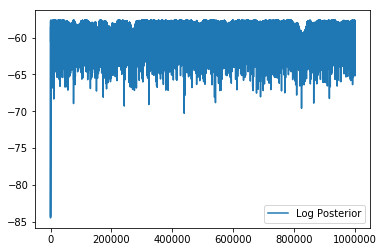

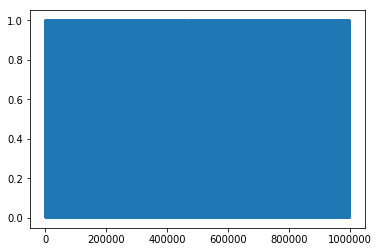

In [37]:
new_lit_devs=recompute_lit_percent_devs(lit_params,computePercentDeviations,thermo_data_rhoL[:,0],thermo_data_Pv[:,0],thermo_data_SurfTens[:,0],lit_devs,thermo_data_rhoL[:,1],thermo_data_Pv[:,1],thermo_data_SurfTens[:,1],Tc_lit[0],rhol_hat_models,Psat_hat_models,SurfTens_hat_models,T_c_hat_models,compound_2CLJ)
# Converts the array with number of model parameters into an array with the number of times there was 1 parameter or 2 parameters
model_count = np.array([len(trace_tuned[trace_tuned[:,0]==0]),len(trace_tuned[trace_tuned[:,0]==1]),len(trace_tuned[trace_tuned[:,0]==2])])


prob_0 = 1.*model_count[0]/(n_iter-tune_for+1)
print('Percent that  model 0 is sampled: '+str(prob_0 * 100.)) #The percent that use 1 parameter model

prob_1 = 1.*model_count[1]/(n_iter-tune_for+1)
print('Percent that model 1 is sampled: '+str(prob_1 * 100.)) #The percent that use two center UA LJ

prob_2 = 1.*model_count[2]/(n_iter-tune_for+1)
print('Percent that model 2 is sampled: '+str(prob_2 * 100.)) #The percent that use two center UA LJ

prob=[prob_0,prob_1,prob_2]

Exp_ratio=prob_0/prob_1

print('Experimental sampling ratio: %2.3f' % Exp_ratio )


print('Detailed Balance')

#These sets of numbers should be roughly equal to each other (If both models are sampled).  If not, big problem 

print(prob_0*transition_matrix[0,1])
print(prob_1*transition_matrix[1,0])
    
print(prob_0*transition_matrix[0,2])
print(prob_2*transition_matrix[2,0])

print(prob_1*transition_matrix[1,2])
print(prob_2*transition_matrix[2,1])

trace_model_0=[]
trace_model_1=[]
trace_model_2=[]
log_trace_0=[]
log_trace_1=[]
log_trace_2=[]

#Initiate data frames for separating model traces

plt.plot(logp_trace,label='Log Posterior')
plt.legend()
plt.show()

plt.plot(trace[:,0])

np.save('trace/trace_'+fname+'.npy',trace_tuned)
np.save('logprob/logprob_'+fname+'.npy',logp_trace)
np.save('percent_dev/percent_dev_'+fname+'.npy',percent_deviation_trace_tuned)
#Save trajectories (can be disabled since they are big files)


for i in range(np.size(trace_tuned,0)):
    if trace_tuned[i,0] == 0:
        trace_model_0.append(trace_tuned[i])
        #log_trace_0.append(logp_trace[i])
    elif trace_tuned[i,0] == 1:
        trace_model_1.append(trace_tuned[i])
        #log_trace_1.append(logp_trace[i])
    elif trace_tuned[i,0] == 2:
        trace_model_2.append(trace_tuned[i])
        #log_trace_2.append(logp_trace[i])        

[0.0, 0.0, 1.0]


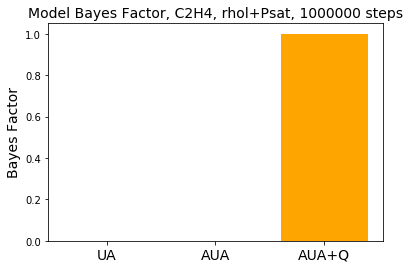

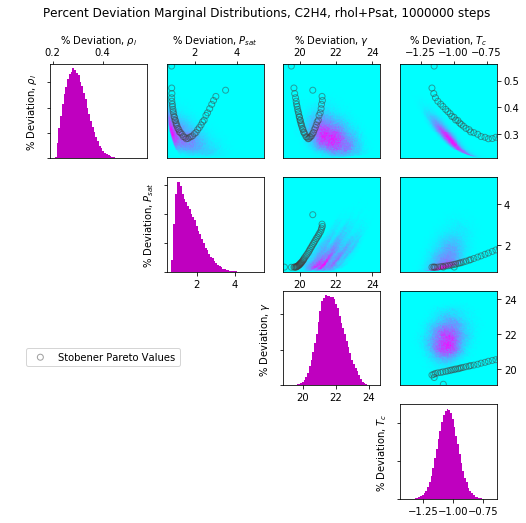

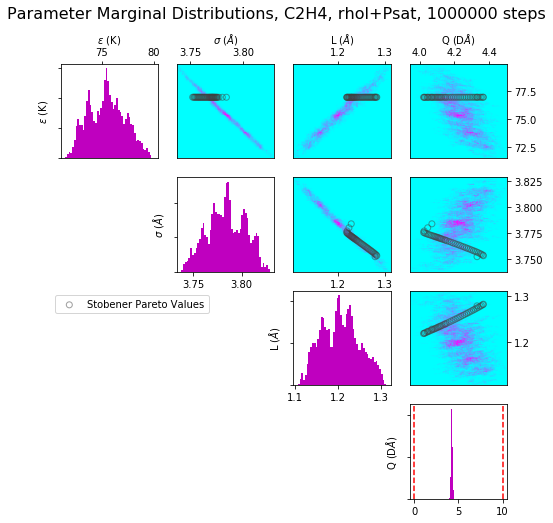

In [12]:
plot_bar_chart(prob,fname,properties,compound,n_iter,n_models)

create_percent_dev_triangle_plot(percent_deviation_trace_tuned,fname,'percent_dev_trace',new_lit_devs,prob,properties,compound,n_iter)

trace_model_0=np.asarray(trace_model_0)
trace_model_1=np.asarray(trace_model_1)
trace_model_2=np.asarray(trace_model_2)


create_param_triangle_plot_4D(trace_model_0,fname,'trace_model_0',lit_params,properties,compound,n_iter,sig_prior,eps_prior,L_prior,Q_prior)
create_param_triangle_plot_4D(trace_model_1,fname,'trace_model_1',lit_params,properties,compound,n_iter,sig_prior,eps_prior,L_prior,Q_prior)
create_param_triangle_plot_4D(trace_model_2,fname,'trace_model_2',lit_params,properties,compound,n_iter,sig_prior,eps_prior,L_prior,Q_prior)

#Plot parameters

get_metadata(compound,properties,sig_prior,eps_prior,L_prior,Q_prior,n_iter,swap_freq,n_points,transition_matrix,prob,attempt_matrix,acceptance_matrix)

